<a href="https://colab.research.google.com/github/rahuliyer/ai_experiments/blob/main/Leopard_or_Cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [1]:
#hide
!pip install -Uqq google-colab fastai duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 37.2 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import DDGS

In [3]:
def search_images(term, max_images=30):
  with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]

        return image_urls

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

cheetah_image_urls = search_images("cheetah photos", max_images=1)
cheetah_image_urls[0]


'https://www.rd.com/wp-content/uploads/2019/11/cheetah-1.jpg'

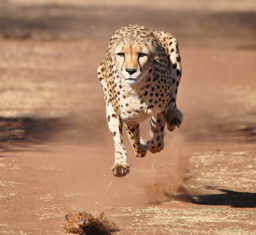

In [5]:
filename = 'cheetah.jpg'
download_url(cheetah_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [6]:
leopard_image_urls = search_images("leopard photos", max_images=1)
leopard_image_urls[0]


'http://www.swaindestinations.com/blog/wp-content/uploads/2014/01/Leopard-45.jpg'

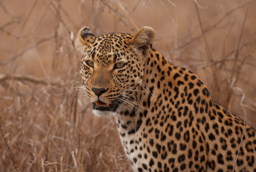

In [7]:
filename = 'leopard.jpg'
download_url(leopard_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [8]:
def download_images_with_interval(urls, dest, batch_size=10, sleep_interval=10):
  index = 0
  while index < len(urls):
    urls_to_download = urls[index:index + batch_size]
    download_images(dest, urls=urls_to_download)
    sleep(sleep_interval)
    index += batch_size


In [9]:
from time import sleep
from pathlib import Path

searches = ['leopard', 'cheetah']

search_urls = {}

for search in searches:
  search_urls[search] = search_images(f"{search} images")


In [10]:
data_dir = Path('leopard_or_cheetah')

max_before_sleep = 10
sleep_interval = 10

for search in search_urls:
  dest_dir = f"{data_dir}/{search}"
  Path(dest_dir).mkdir(exist_ok=True, parents=True)

  download_images_with_interval(search_urls[search], dest_dir)


## Clean failed images

In [11]:
failed = verify_images(get_image_files(data_dir))
failed.map(Path.unlink)

(#0) []

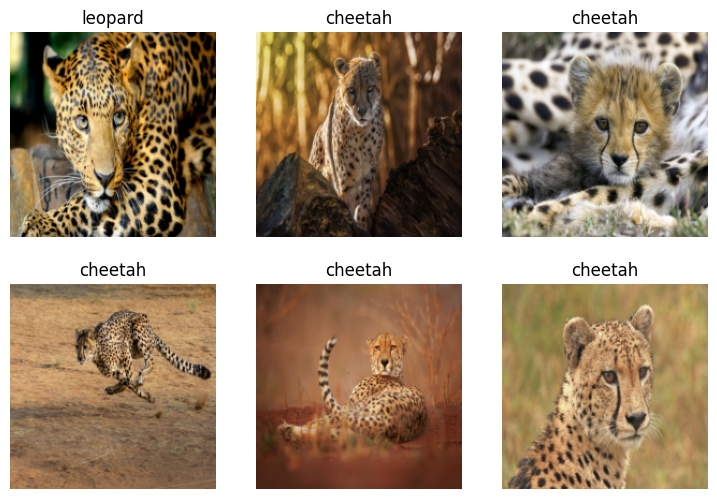

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(data_dir, bs=32)

dls.show_batch(max_n=6)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.214799,1.605336,0.363636,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.421301,1.152728,0.363636,00:17
1,1.329877,0.749468,0.363636,00:15
2,1.063125,0.522360,0.181818,00:16
3,0.867332,0.333837,0.090909,00:15
4,0.693604,0.233971,0.090909,00:15
5,0.573129,0.185187,0.090909,00:14
6,0.487982,0.171440,0.090909,00:15
7,0.424231,0.168636,0.090909,00:16
8,0.373635,0.152933,0.090909,00:15
9,0.334286,0.153377,0.090909,00:15


In [23]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(1), tensor([0.0032, 0.9968]))

In [24]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9999e-01, 5.7154e-06]))

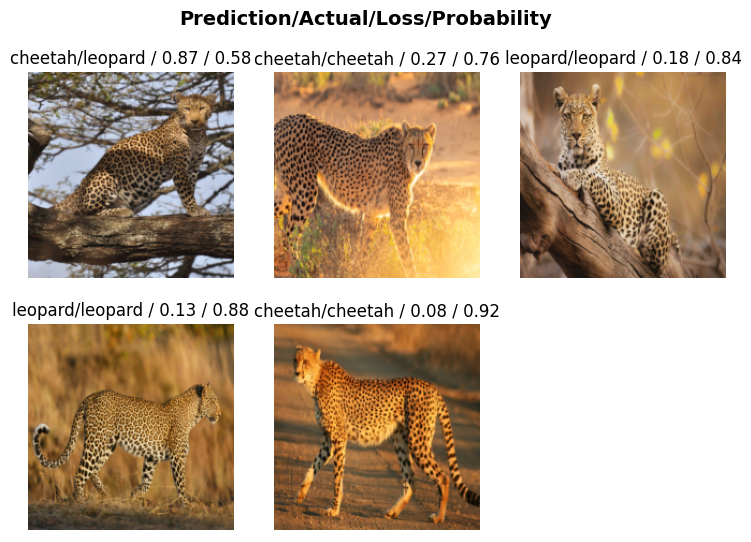

In [26]:
Interpretation.from_learner(learn).plot_top_losses(5)

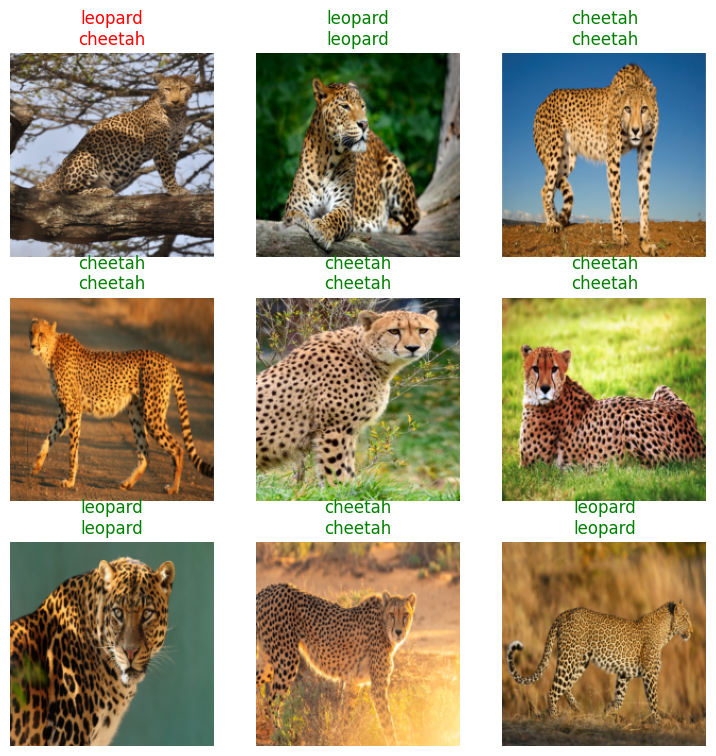

In [36]:
learn.show_results()

Now let's try a bigger model

In [41]:
save_model_cb = SaveModelCallback(monitor='valid_loss')

learn = vision_learner(dls, resnet50, metrics=error_rate, cbs=save_model_cb)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.869927,1.125923,0.636364,00:32


Better model found at epoch 0 with valid_loss value: 1.1259233951568604.


epoch,train_loss,valid_loss,error_rate,time
0,1.738825,0.860692,0.636364,00:29
1,1.402592,0.648098,0.454545,00:30
2,1.009397,0.445088,0.272727,00:30
3,0.811471,0.295166,0.090909,00:28
4,0.654391,0.217513,0.090909,00:28
5,0.541318,0.171082,0.090909,00:31
6,0.459363,0.146061,0.000000,00:28
7,0.403712,0.156899,0.000000,00:28
8,0.360276,0.146308,0.000000,00:32
9,0.321134,0.159949,0.000000,00:28


Better model found at epoch 0 with valid_loss value: 0.8606917858123779.
Better model found at epoch 1 with valid_loss value: 0.6480979323387146.
Better model found at epoch 2 with valid_loss value: 0.445088267326355.
Better model found at epoch 3 with valid_loss value: 0.2951657176017761.
Better model found at epoch 4 with valid_loss value: 0.217513307929039.
Better model found at epoch 5 with valid_loss value: 0.17108158767223358.
Better model found at epoch 6 with valid_loss value: 0.14606143534183502.


In [42]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(1), tensor([0.0976, 0.9024]))

In [43]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([1.0000e+00, 3.9540e-06]))

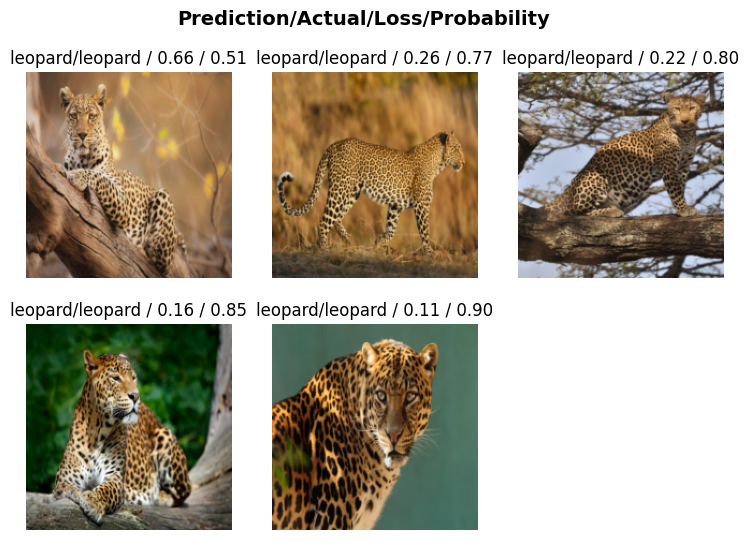

In [44]:
Interpretation.from_learner(learn).plot_top_losses(5)